In [32]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [34]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [35]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [36]:
tf.keras.backend.clear_session()

In [37]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [38]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.793473,36.825,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.793993,34.088,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.794514,30.150,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.795034,31.224,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.795555,33.606,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


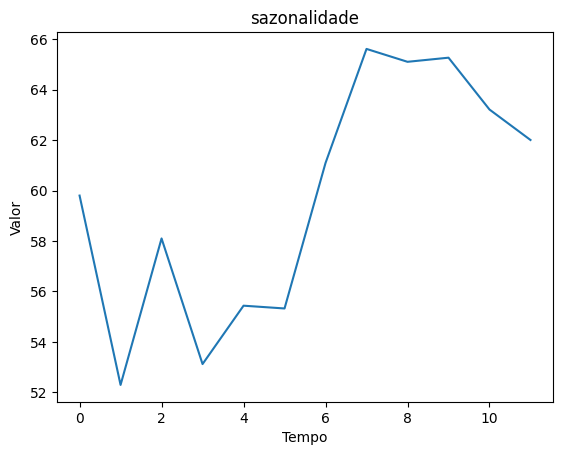

,sazonalidade
sazonalidade,
0,59.798725
1,52.289793
2,58.098576
3,53.116962
4,55.432047
5,55.321868
6,61.091975
7,65.614959
8,65.103883


In [39]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [40]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.793473,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,59.798725,36.825
1,2003-2,0.793993,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,52.289793,34.088
2,2003-3,0.794514,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,58.098576,30.150
3,2003-4,0.795034,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,53.116962,31.224
4,2003-5,0.795555,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,55.432047,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.432047,NaN
245,2023-6,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.321868,NaN
246,2023-7,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.091975,NaN
247,2023-8,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.614959,NaN


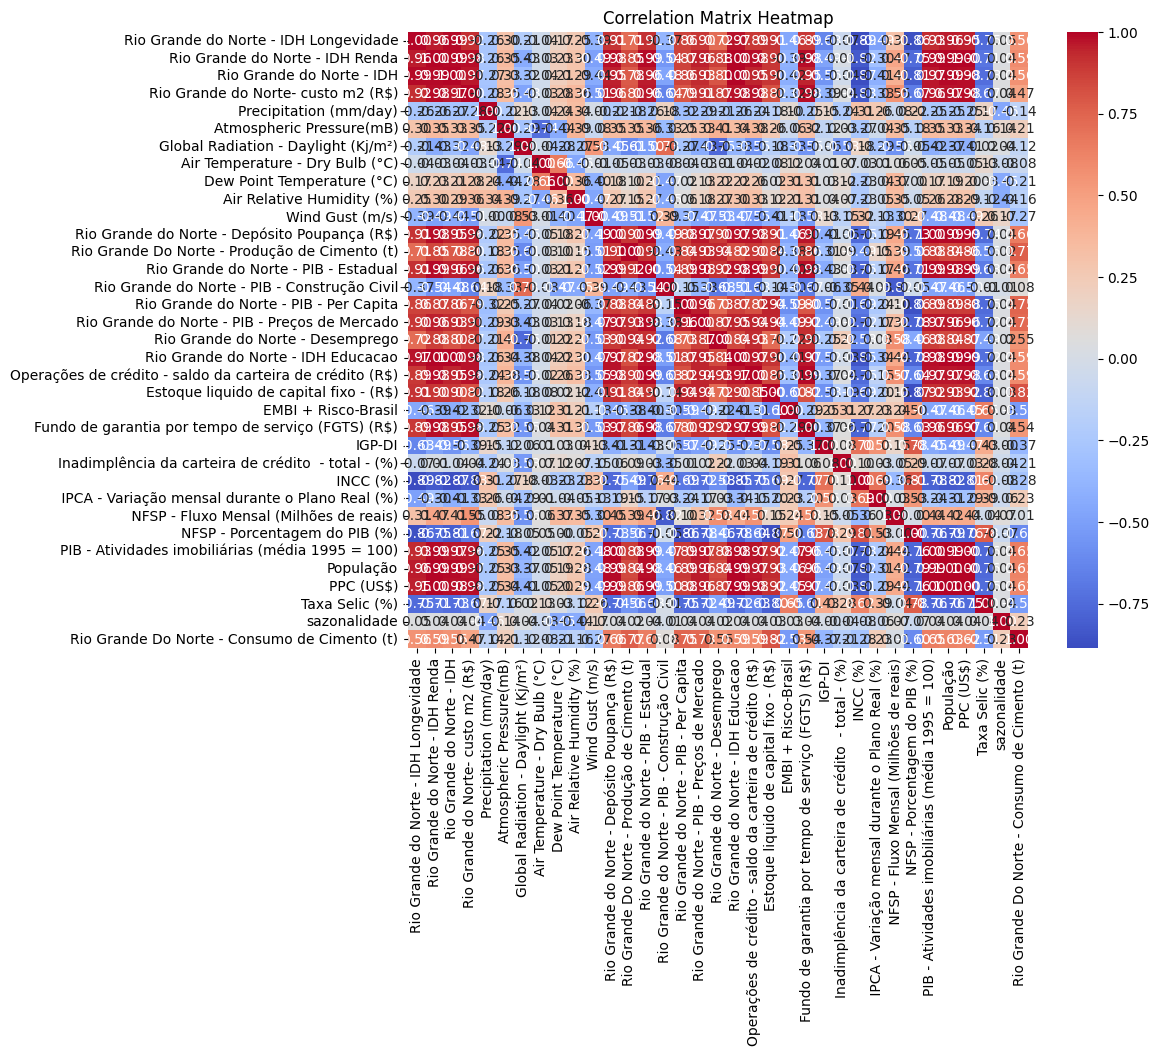

In [41]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [42]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  'sazonalidade'], axis=1)
# data

In [43]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.484227,-1.862662,-2.184058,-1.568323,0.405091,-0.244116,0.011694,-0.041813,-0.443310,-0.468175,0.959558,-1.741178,-1.183161,-1.731345,-0.778207,-2.784513,-2.193066,-0.876481,-2.014365,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.022391
1,-2.434690,-1.840161,-2.147573,-1.546054,0.403024,-0.243762,0.011694,-0.041766,-0.442426,-0.467172,0.955853,-1.724424,-1.192364,-1.711183,-0.728728,-2.703361,-2.146603,-0.878896,-1.986026,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.613070
2,-2.385152,-1.817660,-2.111089,-1.524992,0.401819,-0.243555,0.011694,-0.041738,-0.441911,-0.466587,0.953691,-1.707671,-1.193319,-1.691021,-0.679248,-2.622210,-2.100140,-0.881311,-1.957688,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.347905
3,-2.335614,-1.795159,-2.074605,-1.505549,0.401690,-0.243533,0.011694,-0.041735,-0.441856,-0.466524,0.953460,-1.690917,-1.188108,-1.670859,-0.629768,-2.541059,-2.053677,-0.883727,-1.929349,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.432911
4,-2.286076,-1.772657,-2.038120,-1.487531,0.486947,-0.395830,-0.066857,0.006382,-0.160742,-0.184326,0.696372,-1.674163,-1.175380,-1.650697,-0.580289,-2.459908,-2.007214,-0.886142,-1.901010,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.928681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.144798,1.339329,1.321156,1.829703,-1.374342,1.112250,-0.831294,-0.674988,-0.165163,0.611828,-0.330234,1.304519,0.389536,1.102751,-1.573216,0.457957,0.775635,1.052347,1.313955,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.289179
188,1.131514,1.344547,1.314269,1.850481,-1.307579,0.579226,-0.831872,-0.104968,0.164483,0.278630,-0.313703,1.304824,0.398528,1.092237,-1.561825,0.427807,0.759230,1.051753,1.308731,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.177866
189,1.118229,1.349766,1.307381,1.872337,-1.395653,0.279753,-0.834077,0.519084,0.608997,0.025053,-0.364992,1.305129,0.414978,1.081724,-1.550435,0.397658,0.742826,1.051160,1.303506,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.213470
190,1.104945,1.354984,1.300494,1.894705,-0.806680,-0.100219,-0.841605,0.947304,1.289330,0.304732,-0.534769,1.305434,0.429834,1.071210,-1.539044,0.36

In [44]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      32.845
1      26.809
2      34.465
3      30.563
4      32.574
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 249, dtype: float64

In [45]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.484227,-1.862662,-2.184058,-1.568323,0.405091,-0.244116,0.011694,-0.041813,-0.443310,-0.468175,0.959558,-1.741178,-1.183161,-1.731345,-0.778207,-2.784513,-2.193066,-0.876481,-2.014365,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.022391
1,-2.434690,-1.840161,-2.147573,-1.546054,0.403024,-0.243762,0.011694,-0.041766,-0.442426,-0.467172,0.955853,-1.724424,-1.192364,-1.711183,-0.728728,-2.703361,-2.146603,-0.878896,-1.986026,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.613070
2,-2.385152,-1.817660,-2.111089,-1.524992,0.401819,-0.243555,0.011694,-0.041738,-0.441911,-0.466587,0.953691,-1.707671,-1.193319,-1.691021,-0.679248,-2.622210,-2.100140,-0.881311,-1.957688,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.347905
3,-2.335614,-1.795159,-2.074605,-1.505549,0.401690,-0.243533,0.011694,-0.041735,-0.441856,-0.466524,0.953460,-1.690917,-1.188108,-1.670859,-0.629768,-2.541059,-2.053677,-0.883727,-1.929349,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.432911
4,-2.286076,-1.772657,-2.038120,-1.487531,0.486947,-0.395830,-0.066857,0.006382,-0.160742,-0.184326,0.696372,-1.674163,-1.175380,-1.650697,-0.580289,-2.459908,-2.007214,-0.886142,-1.901010,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.928681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.433835,1.336822,1.384282,1.087695,-0.063817,0.078219,-0.824949,1.272758,2.224095,1.018919,-0.769210,0.841501,1.046207,1.183768,-1.442416,0.625176,0.985411,1.213189,1.318311,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.613070
158,1.427134,1.335410,1.382302,1.112256,0.151559,0.503268,-0.833723,0.893531,2.086497,1.344074,-0.842268,0.859822,1.000373,1.187707,-1.461501,0.642268,0.990347,1.201976,1.319899,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-0.347905
159,1.420433,1.333998,1.380323,1.137089,-0.143256,0.941127,-0.842097,0.246913,1.525954,1.495207,-0.780971,0.878143,0.957199,1.191647,-1.480587,0.659360,0.995283,1.190764,1.321488,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-1.432911
160,1.413732,1.332586,1.378343,1.162595,-0.135603,1.653838,-0.840669,-0.359894,0.735444,1.325284,-0.703275,0.896463,0.908410,1.195587,-1.499673,0.676453,1.

In [46]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.845
1      26.809
2      34.465
3      30.563
4      32.574
        ...  
157    52.722
158    63.109
159    49.356
160    55.725
161    50.796
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 162, dtype: float64

In [47]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [48]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 34)

In [49]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.316834,0.661564,0.458594,0.421883,0.783794,1.227689,-0.826839,-0.856604,-0.710100,0.280557,-0.520793,1.000406,1.480898,0.826780,0.124108,0.924042,0.982707,1.063612,0.579911,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.304064
127,0.311695,0.667547,0.463887,0.440553,0.375374,0.903715,-0.816433,-0.544766,-0.841255,-0.278776,-0.309572,1.029813,1.485581,0.843350,0.061862,0.903284,0.982590,1.075867,0.591504,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.289179
128,0.306556,0.673531,0.469179,0.459912,-0.143529,0.566054,-0.808086,-0.040962,-0.705983,-0.760049,-0.277418,1.059220,1.491421,0.859920,-0.000383,0.882526,0.982474,1.088122,0.603097,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,1.177866
129,0.301417,0.679515,0.474472,0.479025,-0.331752,0.144491,-0.803511,0.426873,-0.579899,-1.193643,-0.245210,1.088626,1.490890,0.876489,-0.062629,0.861768,0.982357,1.100376,0.614690,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.213470
130,0.296277,0.685499,0.479764,0.503072,-0.236640,-0.414682,-0.812130,0.509914,-0.264196,-0.962257,-0.380170,1.118033,1.486995,0.893059,-0.124874,0.841010,0.982241,1.112631,0.626283,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.765686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.144798,1.339329,1.321156,1.829703,-1.374342,1.112250,-0.831294,-0.674988,-0.165163,0.611828,-0.330234,1.304519,0.389536,1.102751,-1.573216,0.457957,0.775635,1.052347,1.313955,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.289179
188,1.131514,1.344547,1.314269,1.850481,-1.307579,0.579226,-0.831872,-0.104968,0.164483,0.278630,-0.313703,1.304824,0.398528,1.092237,-1.561825,0.427807,0.759230,1.051753,1.308731,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.177866
189,1.118229,1.349766,1.307381,1.872337,-1.395653,0.279753,-0.834077,0.519084,0.608997,0.025053,-0.364992,1.305129,0.414978,1.081724,-1.550435,0.397658,0.742826,1.051160,1.303506,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.213470
190,1.104945,1.354984,1.300494,1.894705,-0.806680,-0.100219,-0.841605,0.947304,1.289330,0.304732,-0.534769,1.305434,0.429834,1.071210,-1.539044,0.367509,0.726421,1.050566,1.298282,1.370978,0.332791

In [50]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 34)

In [51]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [52]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [53]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [54]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[4155492314, 1190330216, 412421156, 1185963833, 1089656223, 1716974197, 3197518761, 3526679109, 1394101144, 800917029, 1581473437, 2725859381, 3544965746, 2318703447, 463441612, 1786475893, 1768884464, 1903312966, 3451511785, 659573994, 1184611884, 4204562580, 1541436350, 2956815236, 3707774205, 3819591087, 1980237450, 3818238467, 3039153763, 2034413378, 1360883741, 752685246, 3327915904, 931636995, 1138091460, 3186001329, 2748172396, 2383150929, 461854051, 1567860248, 1496124754, 3997076652, 1754498371, 3344313996, 2183266537, 806636646, 175858617, 3529277893, 2528590249, 4226721740]


Step: 0 ___________________________________________
val_loss: 23.137300491333008
winner_seed: 4155492314


Step: 1 ___________________________________________
val_loss: 22.432777404785156
winner_seed: 1190330216


Step: 2 ___________________________________________
val_loss: 22.325767517089844
winner_seed: 412421156


Step: 3 ___________________________________________
val_loss: 22.294788360595703
winne

In [55]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2652417522

Epoch 1/10000
4/4 [==============================] - 2s 129ms/step - loss: 3840.0669 - val_loss: 219.1431
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 188.3987 - val_loss: 147.2792
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 164.9901 - val_loss: 263.9763
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 142.9744 - val_loss: 450.1370
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 1514.5820 - val_loss: 2251.5276
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 901.5059 - val_loss: 175.4664
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 122.5801 - val_loss: 149.3203
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.7367 - val_loss: 113.4058
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.5631 - val_loss: 180.7458
Epoch 10/10000
4/4 [==============================] - 0s 9ms/ste

4/4 [==============================] - 0s 9ms/step - loss: 23.8901 - val_loss: 47.2882
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.9497 - val_loss: 45.8298
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.0049 - val_loss: 55.2965
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 33.9070 - val_loss: 41.0624
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.9445 - val_loss: 59.1893
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.0866 - val_loss: 45.2786
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.1411 - val_loss: 40.0548
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.7571 - val_loss: 82.2718
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.5465 - val_loss: 61.5919
Epoch 89/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.0354 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 20.3626 - val_loss: 52.5852
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.3599 - val_loss: 39.2874
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.4515 - val_loss: 65.0425
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.1374 - val_loss: 37.7699
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.0785 - val_loss: 60.0191
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.6895 - val_loss: 38.7248
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.1057 - val_loss: 40.0092
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.7374 - val_loss: 45.5894
Epoch 167/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.6548 - val_loss: 42.4536
Epoch 168/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.0129 - v

4/4 [==============================] - 0s 9ms/step - loss: 12.7475 - val_loss: 29.4281
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.1442 - val_loss: 31.9104
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0329 - val_loss: 25.9126
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.6686 - val_loss: 27.1105
Epoch 242/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.7932 - val_loss: 36.7656
Epoch 243/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.5616 - val_loss: 41.7403
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.1670 - val_loss: 26.1806
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8623 - val_loss: 26.0974
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.0450 - val_loss: 30.7125
Epoch 247/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.3241 -

4/4 [==============================] - 0s 10ms/step - loss: 12.4873 - val_loss: 30.0453
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3154 - val_loss: 21.0697
Epoch 319/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.9543 - val_loss: 22.0585
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.1029 - val_loss: 24.4225
Epoch 321/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.5561 - val_loss: 26.3055
Epoch 322/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.4573 - val_loss: 24.8788
Epoch 323/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.1715 - val_loss: 36.2346
Epoch 324/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.6713 - val_loss: 26.7801
Epoch 325/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0982 - val_loss: 24.3519
Epoch 326/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.9889 -

4/4 [==============================] - 0s 10ms/step - loss: 12.6705 - val_loss: 28.9134
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.6335 - val_loss: 31.2667
Epoch 398/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.3022 - val_loss: 40.3863
Epoch 399/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.1643 - val_loss: 22.8615
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.4306 - val_loss: 26.2985
Epoch 401/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0269 - val_loss: 26.2400
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4544 - val_loss: 25.2394
Epoch 403/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.0834 - val_loss: 25.7415
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0340 - val_loss: 26.8921
Epoch 405/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.5346 - 

4/4 [==============================] - 0s 9ms/step - loss: 12.5920 - val_loss: 21.7498
Epoch 476/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2903 - val_loss: 33.6914
Epoch 477/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.5268 - val_loss: 25.8810
Epoch 478/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2154 - val_loss: 24.7513
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.7589 - val_loss: 27.6903
Epoch 480/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7966 - val_loss: 31.8044
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.1741 - val_loss: 27.3782
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7780 - val_loss: 25.3451
Epoch 483/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4951 - val_loss: 25.0920
Epoch 484/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0063 -

4/4 [==============================] - 0s 9ms/step - loss: 9.6516 - val_loss: 24.4954
Epoch 555/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.8198 - val_loss: 25.6672
Epoch 556/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2133 - val_loss: 31.3259
Epoch 557/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.4051 - val_loss: 24.8656
Epoch 558/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3651 - val_loss: 25.6680
Epoch 559/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.9371 - val_loss: 28.4767
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6794 - val_loss: 32.3489
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.4995 - val_loss: 27.2181
Epoch 562/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3061 - val_loss: 29.9169
Epoch 563/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.0120 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 11.4763 - val_loss: 24.9839
Epoch 634/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5559 - val_loss: 27.6983
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5727 - val_loss: 29.1136
Epoch 636/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.8674 - val_loss: 21.2544
Epoch 637/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6896 - val_loss: 22.5229
Epoch 638/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3565 - val_loss: 23.0971
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.5575 - val_loss: 24.2088
Epoch 640/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.1155 - val_loss: 23.7414
Epoch 641/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.1791 - val_loss: 24.2957
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5561 - val_l

Epoch 713/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.1452 - val_loss: 31.4318
Epoch 714/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.9507 - val_loss: 31.7190
Epoch 715/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.4087 - val_loss: 25.7341
Epoch 716/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3626 - val_loss: 26.8016
Epoch 717/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0580 - val_loss: 27.4848
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6571 - val_loss: 27.2738
Epoch 719/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9870 - val_loss: 26.8080
Epoch 720/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8345 - val_loss: 28.6076
Epoch 721/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9303 - val_loss: 27.3792
Epoch 722/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.

Epoch 793/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7269 - val_loss: 25.6399
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3378 - val_loss: 34.5431
Epoch 795/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.9253 - val_loss: 33.6969
Epoch 796/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.4434 - val_loss: 27.3493
Epoch 797/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.7766 - val_loss: 33.3903
Epoch 798/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.5860 - val_loss: 29.4281
Epoch 799/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1113 - val_loss: 32.0039
Epoch 800/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3881 - val_loss: 32.2739
Epoch 801/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.2763 - val_loss: 29.6457
Epoch 802/10000
4/4 [==============================] - 0s 10ms/step - loss: 

4/4 [==============================] - 0s 7ms/step - loss: 7.0159 - val_loss: 31.3035
Epoch 874/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.9368 - val_loss: 38.3703
Epoch 875/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.7305 - val_loss: 34.2814
Epoch 876/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0833 - val_loss: 33.1596
Epoch 877/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.8503 - val_loss: 32.9470
Epoch 878/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.6139 - val_loss: 33.0072
Epoch 879/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.6635 - val_loss: 36.3658
Epoch 880/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.5552 - val_loss: 35.7620
Epoch 881/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6714 - val_loss: 33.6478
Epoch 882/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.4918 - val_loss: 30.

4/4 [==============================] - 0s 10ms/step - loss: 6.2731 - val_loss: 33.7690
Epoch 954/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8005 - val_loss: 35.1170
Epoch 955/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3294 - val_loss: 30.9925
Epoch 956/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8026 - val_loss: 33.4290
Epoch 957/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8080 - val_loss: 40.2272
Epoch 958/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9718 - val_loss: 32.5967
Epoch 959/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4575 - val_loss: 33.6787
Epoch 960/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6204 - val_loss: 32.5139
Epoch 961/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7917 - val_loss: 32.1573
Epoch 962/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6788 - val_lo

4/4 [==============================] - 0s 11ms/step - loss: 7.3750 - val_loss: 33.4061
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6557 - val_loss: 33.1541
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6153 - val_loss: 35.4029
Epoch 1035/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2085 - val_loss: 35.9812
Epoch 1036/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.2918 - val_loss: 35.7381
Epoch 1037/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0274 - val_loss: 34.0361
Epoch 1038/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8349 - val_loss: 35.9217
Epoch 1039/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3695 - val_loss: 35.2642
Epoch 1040/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.5741 - val_loss: 35.0721
Epoch 1041/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5338

4/4 [==============================] - 0s 9ms/step - loss: 6.3798 - val_loss: 32.7149
Epoch 1112/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.7840 - val_loss: 33.4446
Epoch 1113/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1129 - val_loss: 32.4336
Epoch 1114/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.6209 - val_loss: 36.2288
Epoch 1115/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1380 - val_loss: 32.8176
Epoch 1116/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.6616 - val_loss: 38.8255
Epoch 1117/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6184 - val_loss: 33.1291
Epoch 1118/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3672 - val_loss: 31.3847
Epoch 1119/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6274 - val_loss: 33.9878
Epoch 1120/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0431 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 7.3302 - val_loss: 34.0180
Epoch 1191/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7542 - val_loss: 36.1547
Epoch 1192/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2533 - val_loss: 35.5180
Epoch 1193/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5815 - val_loss: 37.0180
Epoch 1194/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1569 - val_loss: 34.5026
Epoch 1194: early stopping


In [56]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [57]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,54.053143,56.553051,59.036163,57.281727,54.219257,52.410908,52.013729,52.21941,53.170483,52.745483,52.721142,52.457642,53.458061,55.489986,57.159019,56.535664,54.560902,52.362694,51.654446,51.736698,52.65353,51.790558,52.404598,53.033138,54.300556,55.510624,55.809521,54.371544,52.652851,51.733501
Target,48.75,59.738,60.303,51.009,48.874,48.506,42.721,32.801,37.638,37.358,31.339,45.311,42.085,48.52,41.365,43.813,43.816,38.245,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,5.303143,3.184948,1.266838,6.272728,5.345257,3.904907,9.292728,19.418411,15.532482,15.387482,21.382141,7.146641,11.373062,6.969986,15.794018,12.722664,10.7449,14.117695,5.573444,13.033699,16.616531,13.360558,7.933598,15.149139,2.715557,1.204624,3.298519,5.100456,1.369148,1.942501


In [58]:
display(mae)
display(mape)

9.081926

0.2267678

In [59]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [60]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined